Matthew Dacre 2091295

Joshua Wacks 2143116

Alex Vogt 20152320

In [2]:
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from tqdm import tqdm

In [3]:
'''
Reading in the images
'''

path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (256, 192)) for ipath, _ in path_pairs])
msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (256, 192)) for _, mpath in path_pairs])

/tmp/ipykernel_7034/2346131470.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (256, 192)) for ipath, _ in path_pairs])
/tmp/ipykernel_7034/2346131470.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (256, 192)) for _, mpath in path_pairs])


In [4]:
def split(images, masks, train_size=0.7, validation_size=0.15, test_size=0.15, seed=42):

    '''
    Splitting data into training, validation and testing sets using slicing with shuffled indices
    '''

    np.random.seed(seed)

    ind = np.arange(len(images))
    np.random.shuffle(ind)

    train = ind[0 :int(len(images)*train_size) + 1]
    val = ind[len(train):len(train) + int(len(images)*validation_size)]
    test = ind[len(train)+len(val):len(train) + len(val) + int(len(images)*test_size)]

    train_imgs = np.array([images[i] for i in train])
    train_masks = np.array([masks[i] for i in train])

    validate_imgs = np.array([images[i] for i in val])
    validate_masks = np.array([masks[i] for i in val])

    test_imgs = np.array([images[i] for i in test])
    test_masks = np.array([masks[i] for i in test])


    return train_imgs, train_masks, validate_imgs, validate_masks, test_imgs, test_masks

def extract_features(image):

    '''
    The image is first blurred, and then the RGB and HSV values are placed in $featuresm a numpy array
    '''

    def norm(arr):
        return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

    image = cv2.GaussianBlur(image, (7, 7), 3)

    features = None
    for rgb_channel in cv2.split(image):
        if features is None:
            features = np.array(rgb_channel.flatten().astype(np.float32))
        else:
            features = np.vstack((features, rgb_channel.flatten().astype(np.float32)))

    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    for hsv_channel in cv2.split(image_hsv):
        if features is None:
            features = np.array(hsv_channel.flatten().astype(np.float32))
        else:
            features = np.vstack((features, norm(hsv_channel.flatten().astype(np.float32))))

    return features
    
def apply_mask(features, mask, background=False):

    '''
    Splitting the data into foregorund/background pixels for trainning the relevent GMM clusters
    '''

    data = []
    mask = mask.astype(bool).flatten()
    if background:
        mask = np.invert(mask)
    for feature in features:
        masked = feature[mask == True]
        data.append(masked.flatten())
    return np.array(data)

In [5]:
'''
Splitting data into train, val, test as well as into forground and background for the training data
'''

x_train, y_train, x_val, y_val, x_test, y_test = split(imgs, msks, train_size=0.7, validation_size=0.15, test_size=0.15)

train_data = np.array([extract_features(train_image) for train_image in x_train])
x_val = np.array([extract_features(train_image) for train_image in x_val])
x_test = np.array([extract_features(train_image) for train_image in x_test])



bg_train = [apply_mask(features, mask, background=True) 
                for features, mask in zip(train_data, y_train)]
fg_train = [apply_mask(features, mask, background=False) 
                for features, mask in zip(train_data, y_train)]

bg_train = np.concatenate(bg_train, axis=1)
fg_train = np.concatenate(fg_train, axis=1)

In [6]:
class params():
    '''
    Datastructure to hold the parameters of a single cluster
    '''
    def __init__(self, lmda, cov, mu):
        self.lmda = lmda
        self.cov = cov
        self.mu = mu

    def diff(self, other):
        '''
        Measure of distance between two centers
        '''
        return np.abs(self.lmda - other.lmda) + euclidean(self.mu, other.mu) + euclidean(self.cov.flatten(), other.cov.flatten())

class GMM():
    def init_params(self, x):
        n = x.shape[1]
        # Initial uniform disctribution
        lmbda = 1 / self.k
        # Initial means
        if self.kmeans:
            if self.kmeans_centers is None:
                if self.verbose: print('Finding K-means Centers')
                self.kmeans_centers = np.squeeze(KMeans(n).fit(x.T.flatten().reshape(-1, 1)).cluster_centers_.reshape((1, n)))
            mu = self.kmeans_centers
        else:
            mu = np.random.choice(x.flatten(), n)
        # Iniital covariance
        cov = np.random.random((n, n))
        # Ensuring cov matrix positive definite
        cov *= cov.T
        cov += n * np.eye(n)
        return params(lmbda, cov, mu)

    def __init__(self, k, tol=1e-4, min_iter=5, max_iter=100, seed=42, kmeans=True, verbose=True):
        self.k = k
        self.tol = tol
        self.min_iter = min_iter
        self.max_iter = max_iter
        self.seed = seed
        self.kmeans = kmeans
        self.kmeans_centers = None
        self.params = None
        self.verbose = verbose

    def e_step(self, x, param):

        '''
        Expectation step of EM algorithm
        '''

        n_samples = x.shape[0]
        responsibilities = np.zeros((n_samples, self.k))
        weighted_gaussians = np.zeros((n_samples, self.k))
        # Get normal distributions using current parameter fold
        for i in range(self.k):
            weighted_gaussians[:, i] = param[i].lmda * \
                                       multivariate_normal.pdf(x, param[i].mu, param[i].cov)
        # Compute responsibility for each cluster
        for i in range(self.k):
            responsibilities[:, i] = weighted_gaussians[:, i] / np.sum(weighted_gaussians, axis=1, initial=1e-10)
        return responsibilities

    def m_step(self, x, res):

        '''
        Maximisation step of EM algorithm using responsibilities res
        '''

        gaussian_parameters = []
        for i in range(self.k):
            k_sum_responsibility = np.sum(res[:, i])
            lmbda = k_sum_responsibility / (np.sum(np.sum(res, axis=1)))
            mu = np.dot(res[:, i], x) / k_sum_responsibility
            standardised_x = x - mu
            cov = np.dot((standardised_x.T * res[:, i]), standardised_x) / k_sum_responsibility
            # Add small value to diagonal to prevent singular matrix
            cov += np.eye(len(cov)) * 1e-10
            gaussian_parameters.append(params(lmbda, cov, mu))
        return gaussian_parameters

    def fit(self, X):

        '''
        Trains model according to hyperparameters defined in initialisation
        '''

        done = False
        i = 0
        param = [self.init_params(X) for _k in range(self.k)]
        while not done and i < self.max_iter:
            # E step
            res = self.e_step(X, param)
            # M step
            param_new = self.m_step(X, res)

            change_total = 0

            for _k, p in enumerate(param_new):
                change_total += p.diff(param[_k])

            done = change_total < self.tol and i >= self.min_iter

            if self.verbose: print(f'Iter {i} : Change {change_total}')

            i += 1
            param = param_new
        # Store learned parameters
        self.params = param

    def predict(self, X):
        n = X.shape[0]
        g_pdfs = np.zeros((X.shape[0], X.shape[1], self.k))

        # Calculate PDF using given parameters to calculate probabilities accoring to learnt parameters
        for i in range(self.k):
            g_pdfs[:,:, i] = self.params[i].lmda * multivariate_normal(self.params[i].mu, self.params[i].cov).pdf(X)
        return np.sum(g_pdfs, axis=2)

In [7]:
HYPER_PARAMS = {
    'gmms' : 5,
    'kmeans' : True,
    'tol' : 1e-3,
    'min_iter' : 0,
    'max_iter' : 100
}

bg = GMM(HYPER_PARAMS['gmms'], kmeans=HYPER_PARAMS['kmeans'], tol=HYPER_PARAMS['tol'], min_iter=HYPER_PARAMS['min_iter'], max_iter=HYPER_PARAMS['max_iter'])
bg.fit(bg_train.T)

fg = GMM(HYPER_PARAMS['gmms'], kmeans=HYPER_PARAMS['kmeans'], tol=HYPER_PARAMS['tol'], min_iter=HYPER_PARAMS['min_iter'], max_iter=HYPER_PARAMS['max_iter'])
fg.fit(fg_train.T)

Finding K-means Centers
Iter 0 : Change 81.41780812067614
Iter 1 : Change 0.03818520792229303
Iter 2 : Change 0.005850184787958498
Iter 3 : Change 0.015153189088758935
Iter 4 : Change 0.0801997504138689
Iter 5 : Change 0.2144970002535775
Iter 6 : Change 0.22054188189249999
Iter 7 : Change 0.23157989890154518
Iter 8 : Change 0.20502055252824072
Iter 9 : Change 0.2179649898839997
Iter 10 : Change 0.18979773876735334
Iter 11 : Change 0.12298881237202497
Iter 12 : Change 0.08217866202918404
Iter 13 : Change 0.06308667526050615
Iter 14 : Change 0.05188527011461948
Iter 15 : Change 0.04537216077298383
Iter 16 : Change 0.04278261965023961
Iter 17 : Change 0.04279708085615223
Iter 18 : Change 0.04249148094350594
Iter 19 : Change 0.04106168059038982
Iter 20 : Change 0.03982767322090157
Iter 21 : Change 0.033979900102734134
Iter 22 : Change 0.025242811210242154
Iter 23 : Change 0.02127971067914302
Iter 24 : Change 0.020630541005626103
Iter 25 : Change 0.01817400375799232
Iter 26 : Change 0.01383

Prediction #1, accuracy:98.09%


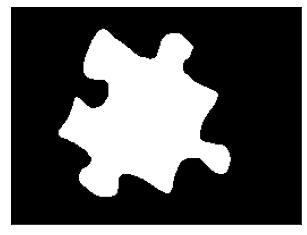

Prediction #2, accuracy:98.76%


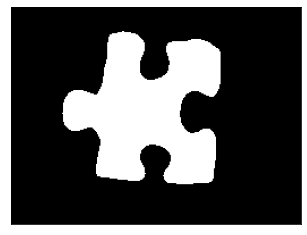

Prediction #3, accuracy:98.35%


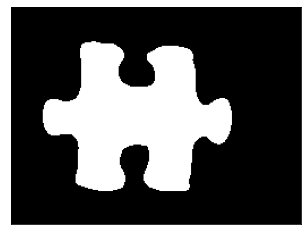

Prediction #4, accuracy:94.03%


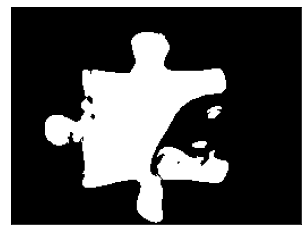

Prediction #5, accuracy:99.06%


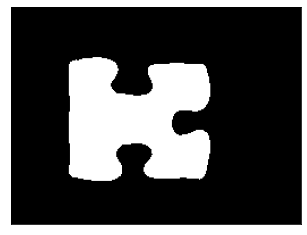

Prediction #6, accuracy:98.25%


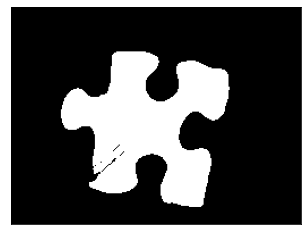

Prediction #7, accuracy:98.18%


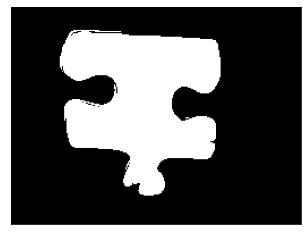

Average accuracy:97.82%


In [8]:
def show_image(image,cs=False,cmap= None, title=None):
    plt.title(title)
    plt.imshow(image.reshape((192, 256)), cmap= cmap)
    plt.xticks([])
    plt.yticks([])

def predict(gmm, X):
    # Calculate PDF using given parameters to calculate probabilities accoring to learnt parameters

    n = X.shape[0]
    g_pdfs = np.zeros((X.shape[0], gmm.k))

    for i in range(gmm.k):
        g_pdfs[:, i] = gmm.params[i].lmda * multivariate_normal(gmm.params[i].mu, gmm.params[i].cov).pdf(X)
    return np.sum(g_pdfs, axis=1)

def predict_foreground(X, bg_gmm, fg_gmm, lmbda):
    '''
    Calculate most likely class of a given datapoint based on foregorund/background probability distributions
    '''
    fg_dist = predict(fg_gmm, X)
    bg_dist = predict(bg_gmm, X)
    y = (lmbda * fg_dist) / ((lmbda * fg_dist) + ((1 - lmbda) * bg_dist))
    return (y >= 0.5).astype(np.float32)


def validate_predictions_accuracy(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda, plot=True):
    """Predictions on validation set, and average results"""

    predict_count = 0
    total_score = 0
    for data, mask in zip(validation_data, validation_masks):
        predict_count += 1
        y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
        score = accuracy_score(y.flatten() + 1, mask.flatten().round() + 1)
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(y, cmap='gray')
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )

def validate_predictions_f1(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda, plot=True):
    """Predictions on validation set, and average results"""

    predict_count = 0
    total_score = 0
    for data, mask in zip(validation_data, validation_masks):
        predict_count += 1
        y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
        score = f1_score(y.flatten() + 1, mask.flatten().round() + 1)
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(y, cmap='gray')
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )

def get_lmda(masks):
    '''
    Calculating the prior
    '''
    f = 0
    t = 0
    for m in masks:
        f += np.sum(m)
        t += np.prod(m.shape)

    return f/t
# Prior using training data
lmda = get_lmda(y_train)
validate_predictions_accuracy(x_val, y_val, bg, fg, lmbda=lmda)

Prediction #1, accuracy:98.48%


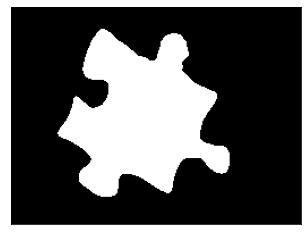

Prediction #2, accuracy:99.12%


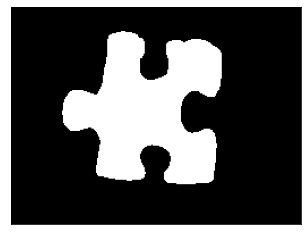

Prediction #3, accuracy:98.95%


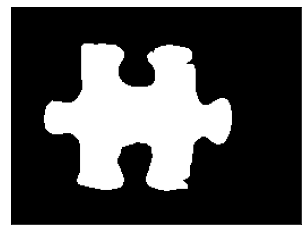

Prediction #4, accuracy:95.35%


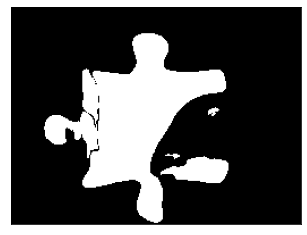

Prediction #5, accuracy:99.42%


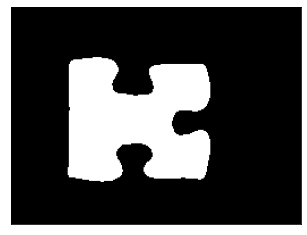

Prediction #6, accuracy:98.72%


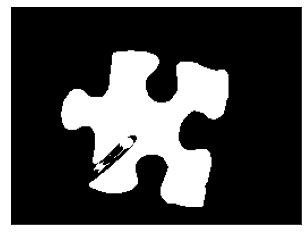

Prediction #7, accuracy:98.87%


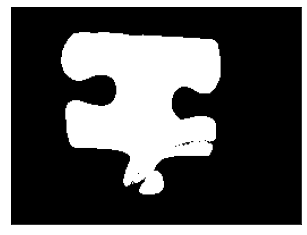

Average accuracy:98.42%


In [18]:
validate_predictions_f1(x_val, y_val, bg, fg, lmbda=lmda)

In [23]:
# Final testing accuracy

lmda = get_lmda(y_train)
print('Accuracy Score: ')
validate_predictions_accuracy(x_test, y_test, bg, fg, lmbda=lmda, plot=False)
print('F1 Score: ')
validate_predictions_f1(x_test, y_test, bg, fg, lmbda=lmda, plot=False)

Accuracy Score: 
Prediction #1, accuracy:96.58%
Prediction #2, accuracy:95.68%
Prediction #3, accuracy:96.0%
Prediction #4, accuracy:98.18%
Prediction #5, accuracy:97.19%
Prediction #6, accuracy:85.8%
Prediction #7, accuracy:97.61%
Average accuracy:95.29%
F1 Score: 
Prediction #1, accuracy:97.7%
Prediction #2, accuracy:97.07%
Prediction #3, accuracy:97.37%
Prediction #4, accuracy:98.7%
Prediction #5, accuracy:98.12%
Prediction #6, accuracy:91.27%
Prediction #7, accuracy:98.4%
Average accuracy:96.95%


In [38]:
# Training accuracy

lmda = get_lmda(y_train)
print('Accuracy Score: ')
validate_predictions_accuracy(train_data, y_train, bg, fg, lmbda=lmda, plot=False)
print('F1 Score: ')
validate_predictions_f1(train_data, y_train, bg, fg, lmbda=lmda, plot=False)

Accuracy Score: 
Prediction #1, accuracy:98.37%
Prediction #2, accuracy:97.41%
Prediction #3, accuracy:97.88%
Prediction #4, accuracy:97.75%
Prediction #5, accuracy:98.38%
Prediction #6, accuracy:98.16%
Prediction #7, accuracy:97.69%
Prediction #8, accuracy:98.78%
Prediction #9, accuracy:98.88%
Prediction #10, accuracy:90.63%
Prediction #11, accuracy:98.65%
Prediction #12, accuracy:98.23%
Prediction #13, accuracy:98.47%
Prediction #14, accuracy:98.58%
Prediction #15, accuracy:99.09%
Prediction #16, accuracy:97.71%
Prediction #17, accuracy:98.14%
Prediction #18, accuracy:96.06%
Prediction #19, accuracy:98.13%
Prediction #20, accuracy:92.45%
Prediction #21, accuracy:98.03%
Prediction #22, accuracy:97.07%
Prediction #23, accuracy:97.82%
Prediction #24, accuracy:98.98%
Prediction #25, accuracy:99.08%
Prediction #26, accuracy:98.46%
Prediction #27, accuracy:95.56%
Prediction #28, accuracy:97.24%
Prediction #29, accuracy:99.25%
Prediction #30, accuracy:98.7%
Prediction #31, accuracy:97.66%
P

6-fold Validation

In [27]:
def k_fold_val(imgs, masks, k, seed=42):
    '''
    Performing k-fold validation
    '''
    np.random.seed(seed)
    def k_fold_split():
        '''
        Splitting data into folds using index slicing
        '''
        ind = np.arange(len(imgs))
        np.random.shuffle(ind)

        l_split = len(imgs)//k

        s_im = []
        s_msk = []

        for i in range(k-1):
            s_im.append(imgs[i*l_split:(i+1)*l_split])
            s_msk.append(masks[i*l_split:(i+1)*l_split])

        return s_im, s_msk

    def apply_mask(features, mask, background=False):

        data = []
        mask = mask.astype(bool).flatten()
        if background:
            mask = np.invert(mask)
        for feature in features:
            masked = feature[mask == True]
            data.append(masked.flatten())
        return np.array(data)

    def validate_predictions(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda):
        """Predictions on validation set, and average results"""

        def predict(gmm, X):
    
            n = X.shape[0]
            g_pdfs = np.zeros((X.shape[0], gmm.k))

            for i in range(gmm.k):
                g_pdfs[:, i] = gmm.params[i].lmda * multivariate_normal(gmm.params[i].mu, gmm.params[i].cov).pdf(X)
            return np.sum(g_pdfs, axis=1)

        def predict_foreground(X, bg_gmm, fg_gmm, lmbda):

            fg_dist = predict(fg_gmm, X)
            bg_dist = predict(bg_gmm, X)
            y = (lmbda * fg_dist) / ((lmbda * fg_dist) + ((1 - lmbda) * bg_dist))
            return (y >= 0.5).astype(np.float32)

        predict_count = 0
        total_score_1 = 0
        total_score_2 = 0
        for data, mask in zip(validation_data, validation_masks):
            predict_count += 1
            y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
            score_1 = accuracy_score(y.flatten() + 1, mask.flatten().round() + 1)
            score_2 = f1_score(y.flatten() + 1, mask.flatten().round() + 1)
            total_score_1 += score_1
            total_score_2 += score_2

        return (total_score_1/predict_count, total_score_2/predict_count)

    def get_lmda(masks):
        f = 0
        t = 0
        for m in masks:
            f += np.sum(m)
            t += np.prod(m.shape)

        return f/t

    def train_and_test(train_im, train_msk, val_im, val_msk):
        train_fg = np.concatenate([apply_mask(feat, mask, background=False) for feat, mask in zip(train_im, train_msk)], axis=1)
        train_bg = np.concatenate([apply_mask(feat, mask, background=True) for feat, mask in zip(train_im, train_msk)], axis=1)

        fg = GMM(5, kmeans=True, tol=1e-3, min_iter=0, max_iter=50, verbose=False)
        fg.fit(train_fg.T)

        bg = GMM(5, kmeans=True, tol=1e-3, min_iter=0, max_iter=50, verbose=False)
        bg.fit(train_bg.T)

        lmda = get_lmda(val_msk)

        return validate_predictions(val_im, val_msk, bg, fg, lmda)

    s_im, s_msk = k_fold_split()
    acc = []
    for fold in tqdm(range(k-1)):
        train_im = s_im[:fold] + s_im[fold+1:]
        train_im = np.array([item for sublist in train_im for item in sublist])

        train_msks = s_msk[:fold] + s_msk[fold+1:]
        train_msks = np.array([item for sublist in train_msks for item in sublist])

        val_im = np.array(s_im[fold])
        val_msk = np.array(s_msk[fold])

        train_im_aug = np.array([extract_features(image) for image in train_im])
        val_im_aug = np.array([extract_features(image) for image in val_im])

        acc.append(train_and_test(train_im_aug, train_msks, val_im_aug, val_msk))        

    return acc


acc = k_fold_val(imgs, msks, 6)

100%|██████████| 5/5 [08:01<00:00, 96.32s/it] 


In [37]:
print(f'Average accuracy score in k-fold validation: {np.average([item[0] for item in acc])*100:.2f}%')
print(f'Average f1 score in k-fold validation: {np.average([item[1] for item in acc])*100:.2f}%')

Average accuracy score in k-fold validation: 96.43%
Average f1 score in k-fold validation: 97.53%


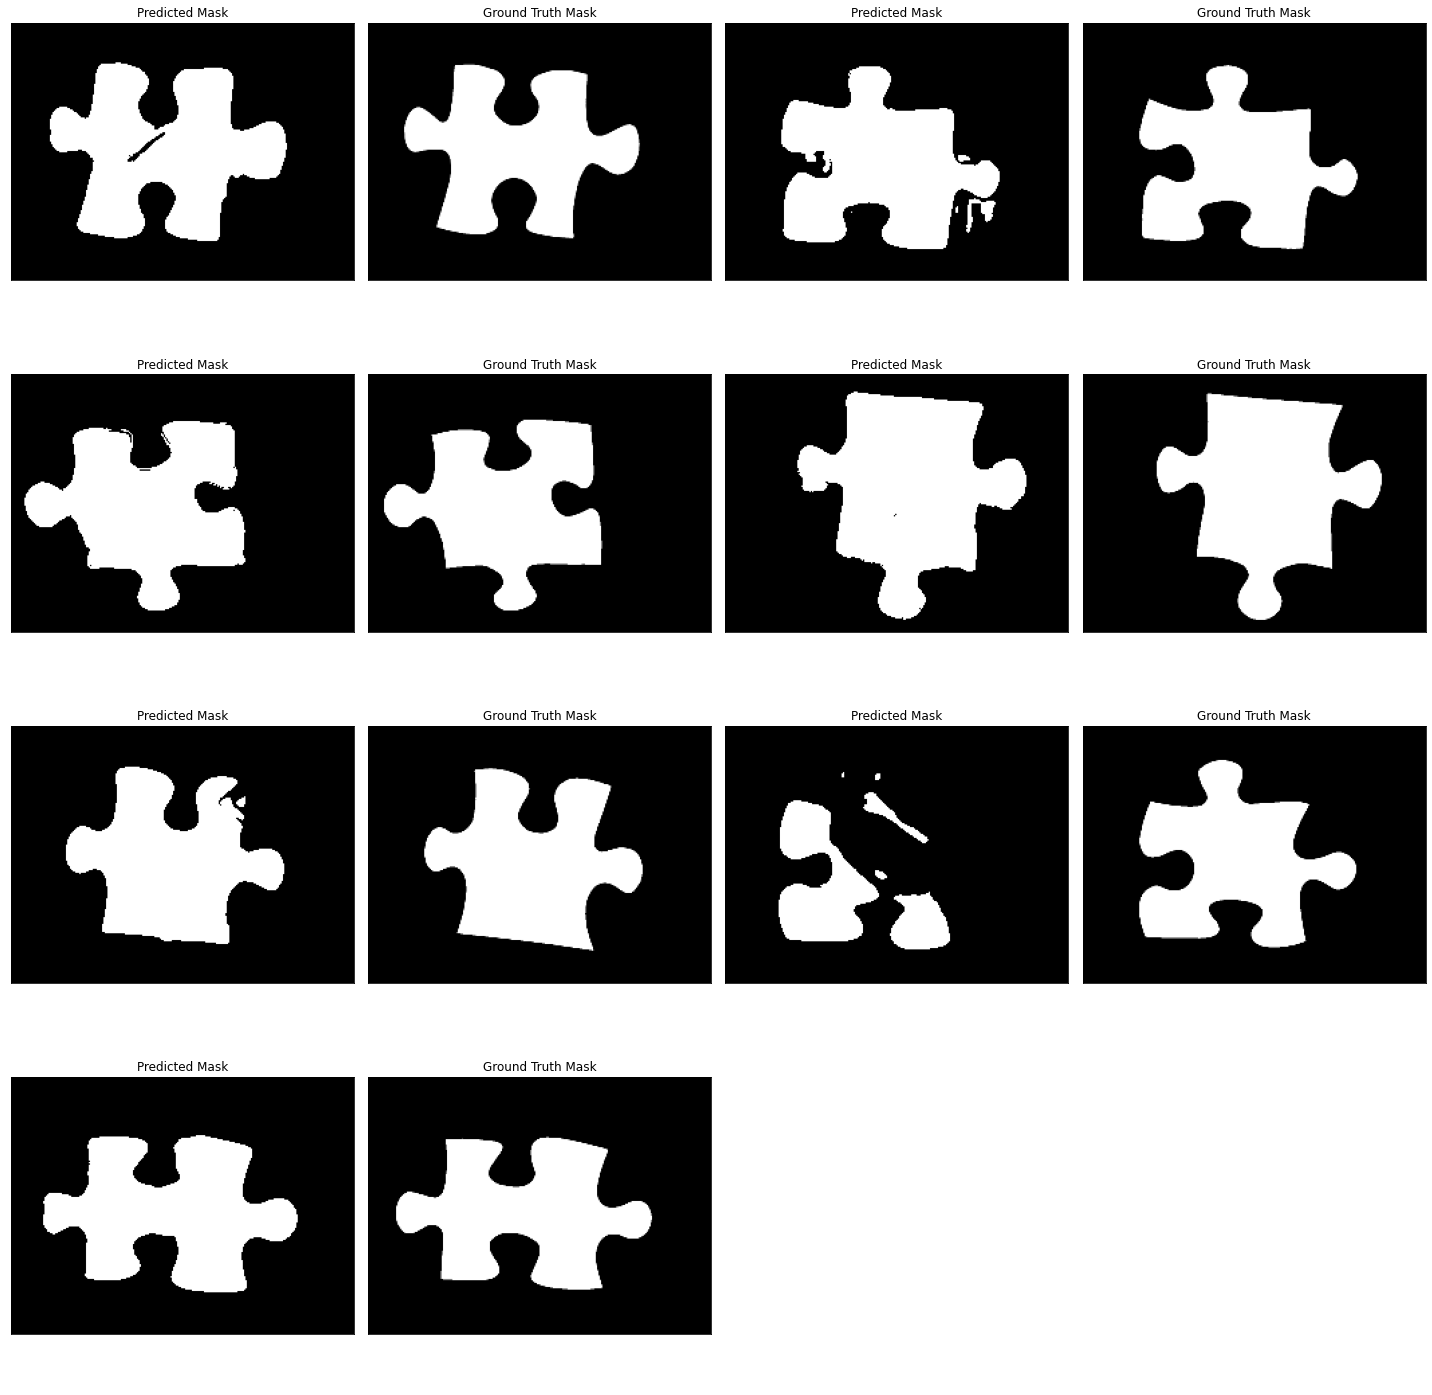

In [16]:
# Generating plots seen in appendix C of the report

lmda = get_lmda(y_train)
preds = []
for data, mask in zip(x_test, y_test):
    preds.append(predict_foreground(data.T, bg, fg, lmbda=lmda).reshape(192, 256))

fig, axs = plt.subplots(4, 4, figsize=(20, 20), facecolor='white')
ax = axs.ravel()

try:
    for i in range(0, 15, 2):
        ax[i].imshow(preds[i//2], cmap='gray')
        ax[i].set_title('Predicted Mask')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        ax[i+1].imshow(y_test[i//2], cmap='gray')
        ax[i+1].set_title('Ground Truth Mask')
        ax[i+1].set_xticks([])
        ax[i+1].set_yticks([])
except:
    ax[-2].axis('off')
    ax[-1].axis('off')
fig.tight_layout()
plt.show()